In [1]:
import os
import scipy
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from utils import data_utils
from models import HVATNet_v3_FineTune


def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(42)

Загрузка данных, сгенерированных из ЭМГ

In [37]:
def load_data_from_mat(path, variable_name):
    mat_content = scipy.io.loadmat(path)
    mat_variable = mat_content[variable_name]
    return np.array(mat_variable)


Fs = 500  # sampling frequency . Set to your value
T = 1200  # total time of the simulation, seconds - set you value, you can
N_EMG = 8  # number of EMG channels
N_joints = 20  # number of decodede angles

path = "../gen_data/v2/"
s = load_data_from_mat(os.path.join(path, "./s.mat"), "s")
s_env = load_data_from_mat(os.path.join(path, "./s_env.mat"), "s_env")
s_env = s_env[:, Fs : -(Fs - 1)]  # Обержем согласно том, как это делается в matlab

t = load_data_from_mat(os.path.join(path, "./t.mat"), "t")
t = t[:, Fs : -(Fs - 1)]  # Обержем согласно том, как это делается в matlab

vel1 = load_data_from_mat(os.path.join(path, "./vel1.mat"), "vel1")
vel2 = load_data_from_mat(os.path.join(path, "./vel2.mat"), "vel2")

data = {"myo": s.T, "angles1": vel1.T, "angles2": vel2.T, "ts": t.T}

# Переходим от частоты 500Гц в частоту 250Гц
data["myo"] = data["myo"][::2]
data["angles1"] = data["angles1"][::2]
data["angles2"] = data["angles2"][::2]
data["ts"] = data["ts"][::2]

# Фильтрация данных
empty = np.empty(data["myo"].shape)  # data["myo"].shape = (sequence_lenght, n_electrodes)

std_range = 6

for electrode in range(data["myo"].shape[1]):
    da = data["myo"][:, electrode]
    dat = da[~np.isnan(da)]

    samp_freq = 250  # Sample frequency (Hz)
    notch_freq = 50.0  # Frequency to be removed from signal (Hz)
    quality_factor = 30.0  # Quality factor

    b_notch, a_notch = scipy.signal.iirnotch(notch_freq, quality_factor, samp_freq)
    freq, h = scipy.signal.freqz(b_notch, a_notch, fs=samp_freq)

    emg_filt = scipy.signal.filtfilt(b_notch, a_notch, dat)
    emg_filt_norm = data_utils.butter_highpass_filter(emg_filt, 10, 125, order=5)
    diff_in_length = len(da) - len(emg_filt_norm)
    emg_filt_norm = np.append(emg_filt_norm, np.zeros(diff_in_length) + np.nan)

    empty[:, electrode] = emg_filt_norm

# Удаление выбросов
cleanest = np.empty(data["myo"].shape)
std_threshold = std_range * np.max(np.nanstd(empty, axis=0))

for electrode in range(data["myo"].shape[1]):
    one_signal = empty[:, electrode]
    one_signal_clean = one_signal[~np.isnan(one_signal)]

    clear_up = np.where(
        one_signal_clean < std_threshold, one_signal_clean, std_threshold
    )
    clear_down = np.where(clear_up > -1 * std_threshold, clear_up, -1 * std_threshold)

    diff_in_length = len(one_signal) - len(clear_down)
    final_signal = np.append(clear_down, np.zeros(diff_in_length) + np.nan)
    cleanest[:, electrode] = final_signal

# MinMax нормализация
maxx = np.nanmax(cleanest)
minn = np.nanmin(cleanest)

# normalize data based on the whole set of signals.
# EMG preproc: normalize -> (-1, 1) range as audio.
emg_min_max = (cleanest - minn) / (maxx - minn)  # (0, 1)
emg_min_max = 2 * emg_min_max - 1

# I do scaling on the whole dataset, but that creates vertical shifts (+- 0.2) in data, so i substract this shift
data_myo = emg_min_max - np.nanmean(emg_min_max, axis=0)
data["myo"] = data_myo


# Определяем класс Dataset
class EMGDataset(Dataset):
    def __init__(
        self, emg_data, angles_data, window_size=256, stride=128, downsample_target=8
    ):
        assert len(emg_data) == len(
            angles_data
        ), "Data and target lengths do not match."

        self.emg_data = emg_data
        self.angles_data = angles_data
        self.window_size = window_size
        self.stride = stride
        self.downsample_target = downsample_target

        # Calculate the number of possible segments
        self.num_samples = (len(emg_data) - window_size) // stride + 1

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        start = idx * self.stride
        end = start + self.window_size

        emg_sample = self.emg_data[start:end]
        angles_sample = self.angles_data[start:end]

        if self.downsample_target:
            angles_sample = angles_sample[:: self.downsample_target]

        emg_sample_tensor = torch.tensor(emg_sample, dtype=torch.float32).transpose(
            0, 1
        )
        angles_sample_tensor = torch.tensor(
            angles_sample, dtype=torch.float32
        ).transpose(0, 1)

        return emg_sample_tensor, angles_sample_tensor


# Определение размера обучения
train_size = int(0.8 * len(data["myo"]))

# Разделение данных на трейн и тест
train_emg_data = data["myo"][:train_size]
test_emg_data = data["myo"][train_size:]

train_angles_data = data["angles2"][:train_size]
test_angles_data = data["angles2"][train_size:]

# Проверка форм
print("Train Data Shape:", train_emg_data.shape)
print("Test Data Shape:", test_emg_data.shape)

# Создаем экземпляр Dataset
train_dataset = EMGDataset(
    train_emg_data, train_angles_data, window_size=256, stride=128, downsample_target=8
)
test_dataset = EMGDataset(
    test_emg_data, test_angles_data, window_size=256, stride=128, downsample_target=8
)

# Используем встроенный DataLoader
batch_size = 256
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True
)

# Пример получения данных из train_loader
for emg_batch, angles_batch in train_loader:
    print("Train EMG Batch Shape:", emg_batch.shape)  # Ожидается: (batch_size, 8, 256)
    print(
        "Train Angles Batch Shape:", angles_batch.shape
    )  # Ожидается: (batch_size, 20, 256)
    break  # Выводим только первую итерацию для примера

# Пример получения данных из test_loader
for emg_batch, angles_batch in test_loader:
    print("Test EMG Batch Shape:", emg_batch.shape)  # Ожидается: (batch_size, 8, 256)
    print(
        "Test Angles Batch Shape:", angles_batch.shape
    )  # Ожидается: (batch_size, 20, 256)
    break  # Выводим только первую итерацию для примера

Train Data Shape: (239600, 8)
Test Data Shape: (59901, 8)
Train EMG Batch Shape: torch.Size([256, 8, 256])
Train Angles Batch Shape: torch.Size([256, 20, 32])
Test EMG Batch Shape: torch.Size([256, 8, 256])
Test Angles Batch Shape: torch.Size([256, 20, 32])


Генерация простого сигнала

In [3]:
# Параметры сигнала
duration = 20 * 60  # 4 минуты в секундах
sampling_rate = 500  # Гц
num_samples = duration * sampling_rate

# Создание многоканального сигнала (8 каналов)
t = np.linspace(0, duration, num_samples, endpoint=False)
signal = np.array([np.sin(2 * np.pi * 5 * t + 0.5 * np.random.randn(*t.shape)) for _ in range(8)])  # 5 Гц - частота синусоиды

# Применение линейного преобразования
amplitude_factor = 2.0
offset = 0.5
transformed_signal = amplitude_factor * signal + offset

# Создание многоканальных целей (20 каналов)
additional_channels = 12  # количество дополнительных каналов
additional_signals = np.array([np.abs(transformed_signal[chan % 8] + 0.1 * np.random.randn(*t.shape)) for chan in range(additional_channels)])
targets = np.vstack((transformed_signal, additional_signals))  # Совмещение для общего числа 20 каналов

# Траспонирование
signal = signal.T
targets = targets.T

# Downsample в 250Гц
signal = signal[::2]
targets = targets[::2]

# Синхронизация размера со сгенерированными данными EMG
signal = signal[:299501]
targets = targets[:299501]

# Определяем класс Dataset
class SimpleEMGDataset(Dataset):
    def __init__(
        self, emg_data, angles_data, window_size=256, stride=128, downsample_target=8
    ):
        assert len(emg_data) == len(angles_data), "Data and target lengths do not match."

        self.emg_data = emg_data
        self.angles_data = angles_data
        self.window_size = window_size
        self.stride = stride
        self.downsample_target = downsample_target

        # Calculate the number of possible segments
        self.num_samples = (len(emg_data) - window_size) // stride + 1

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        start = idx * self.stride
        end = start + self.window_size

        emg_sample = self.emg_data[start:end]
        angles_sample = self.angles_data[start:end]

        if self.downsample_target:
            angles_sample = angles_sample[:: self.downsample_target]

        emg_sample_tensor = torch.tensor(emg_sample, dtype=torch.float32).transpose(0, 1)
        angles_sample_tensor = torch.tensor(angles_sample, dtype=torch.float32).transpose(0, 1)

        return emg_sample_tensor, angles_sample_tensor   


# Определение размера обучения
train_size = int(0.8 * len(data["myo"]))

# Разделение данных на трейн и тест
train_emg_data = signal[:train_size]
test_emg_data = signal[train_size:]

train_angles_data = targets[:train_size]
test_angles_data = targets[train_size:]

# Проверка форм
print("Train Data Shape:", train_emg_data.shape)
print("Test Data Shape:", test_emg_data.shape)

# Создаем экземпляр Dataset
simple_emg_train_dataset = SimpleEMGDataset(
    train_emg_data, train_angles_data, window_size=256, stride=128, downsample_target=8
)
simple_emg_test_dataset = SimpleEMGDataset(
    test_emg_data, test_angles_data, window_size=256, stride=128, downsample_target=8
)

# Используем встроенный DataLoader
batch_size = 256
simple_emg_train_loader = DataLoader(
    simple_emg_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True
)
simple_emg_test_loader = DataLoader(
    simple_emg_test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True
)

# Пример получения данных из train_loader
for emg_batch, angles_batch in simple_emg_train_loader:
    print("Train EMG Batch Shape:", emg_batch.shape)  # Ожидается: (batch_size, 8, 256)
    print(
        "Train Angles Batch Shape:", angles_batch.shape
    )  # Ожидается: (batch_size, 20, 256)
    break  # Выводим только первую итерацию для примера

# Пример получения данных из test_loader
for emg_batch, angles_batch in simple_emg_test_loader:
    print("Test EMG Batch Shape:", emg_batch.shape)  # Ожидается: (batch_size, 8, 256)
    print(
        "Test Angles Batch Shape:", angles_batch.shape
    )  # Ожидается: (batch_size, 20, 256)
    break  # Выводим только первую итерацию для примера

Train Data Shape: (239600, 8)
Test Data Shape: (59901, 8)
Train EMG Batch Shape: torch.Size([256, 8, 256])
Train Angles Batch Shape: torch.Size([256, 20, 32])
Test EMG Batch Shape: torch.Size([256, 8, 256])
Test Angles Batch Shape: torch.Size([256, 20, 32])


#### Полносвязная нейронная сеть

In [14]:
# Определение устройства (CPU или CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Определение модели с полносвязной нейронной сетью
class FullyConnectedModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=128, output_channels=20, output_sequence_length=32):
        super(FullyConnectedModel, self).__init__()
        self.flatten = nn.Flatten()
        # Входной слой: 8 входных каналов * 256 временных шагов
        self.fc1 = nn.Linear(input_size * 256, hidden_size)
        self.relu = nn.ReLU()
        # Выходной слой должен формировать 20 каналов, каждый из 32 элементов
        self.fc2 = nn.Linear(hidden_size, output_channels * output_sequence_length)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # Перестроим тензор в форму (batch_size, output_channels, output_sequence_length)
        x = x.view(x.size(0), 20, 32)
        return x

Gen EMG данные

In [15]:
# Создание модели и перенесение ее на устройство
model = FullyConnectedModel(input_size=8, hidden_size=128, output_channels=20, output_sequence_length=32).to(device)

# Используем функцию потерь и оптимизатор AdamW
criterion = nn.L1Loss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

# Количество эпох
num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Установка режима тренировки
    model.train()
    running_loss = 0.0

    # Добавляем tqdm для тренировочного цикла
    train_loader_tqdm = tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False
    )

    for emg_batch, angles_batch in train_loader_tqdm:
        # Перенос данных на устройство
        emg_batch = emg_batch.to(device)
        angles_batch = angles_batch.to(device)

        # Прямой проход
        outputs = model(emg_batch)
        loss = criterion(outputs, angles_batch)

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0

    # Добавляем tqdm для валидационного цикла
    test_loader_tqdm = tqdm(
        test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False
    )

    with torch.no_grad():
        for emg_batch, angles_batch in test_loader_tqdm:
            # Перенос данных на устройство
            emg_batch = emg_batch.to(device)
            angles_batch = angles_batch.to(device)

            # Прямой проход
            outputs = model(emg_batch)
            loss = criterion(outputs, angles_batch)
            val_loss += loss.item()

    average_val_loss = val_loss / len(test_loader)

    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)

    # Обновляем основную строку вывода tqdm
    tqdm.write(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}"
    )

Epoch [1/100], Train Loss: 0.1981, Validation Loss: 0.1965


Epoch [2/100], Train Loss: 0.1967, Validation Loss: 0.1958


Epoch [3/100], Train Loss: 0.1956, Validation Loss: 0.1951


Epoch [4/100], Train Loss: 0.1948, Validation Loss: 0.1946


Epoch [5/100], Train Loss: 0.1939, Validation Loss: 0.1941


Epoch [6/100], Train Loss: 0.1929, Validation Loss: 0.1937


Epoch [7/100], Train Loss: 0.1922, Validation Loss: 0.1934


Epoch [8/100], Train Loss: 0.1916, Validation Loss: 0.1931


Epoch [9/100], Train Loss: 0.1909, Validation Loss: 0.1928


Epoch [10/100], Train Loss: 0.1904, Validation Loss: 0.1926


Epoch [11/100], Train Loss: 0.1897, Validation Loss: 0.1924


Epoch [12/100], Train Loss: 0.1894, Validation Loss: 0.1922


Epoch [13/100], Train Loss: 0.1890, Validation Loss: 0.1921


Epoch [14/100], Train Loss: 0.1885, Validation Loss: 0.1920


Epoch [15/100], Train Loss: 0.1882, Validation Loss: 0.1919


Epoch [16/100], Train Loss: 0.1878, Validation Loss: 0.1918


Epoch [17/100], Train Loss: 0.1873, Validation Loss: 0.1917


Epoch [18/100], Train Loss: 0.1870, Validation Loss: 0.1916


Epoch [19/100], Train Loss: 0.1867, Validation Loss: 0.1916


Epoch [20/100], Train Loss: 0.1859, Validation Loss: 0.1915


Epoch [21/100], Train Loss: 0.1857, Validation Loss: 0.1915


Epoch [22/100], Train Loss: 0.1855, Validation Loss: 0.1915


Epoch [23/100], Train Loss: 0.1851, Validation Loss: 0.1914


Epoch [24/100], Train Loss: 0.1846, Validation Loss: 0.1914


Epoch [25/100], Train Loss: 0.1843, Validation Loss: 0.1914


Epoch [26/100], Train Loss: 0.1841, Validation Loss: 0.1914


Epoch [27/100], Train Loss: 0.1836, Validation Loss: 0.1914


Epoch [28/100], Train Loss: 0.1834, Validation Loss: 0.1914


Epoch [29/100], Train Loss: 0.1830, Validation Loss: 0.1914


Epoch [30/100], Train Loss: 0.1826, Validation Loss: 0.1915


Epoch [31/100], Train Loss: 0.1824, Validation Loss: 0.1915


Epoch [32/100], Train Loss: 0.1820, Validation Loss: 0.1915


Epoch [33/100], Train Loss: 0.1816, Validation Loss: 0.1915


Epoch [34/100], Train Loss: 0.1811, Validation Loss: 0.1916


Epoch [35/100], Train Loss: 0.1809, Validation Loss: 0.1916


Epoch [36/100], Train Loss: 0.1804, Validation Loss: 0.1916


Epoch [37/100], Train Loss: 0.1801, Validation Loss: 0.1917


Epoch [38/100], Train Loss: 0.1795, Validation Loss: 0.1917


Epoch [39/100], Train Loss: 0.1792, Validation Loss: 0.1918


Epoch [40/100], Train Loss: 0.1788, Validation Loss: 0.1918


Epoch [41/100], Train Loss: 0.1784, Validation Loss: 0.1919


Epoch [42/100], Train Loss: 0.1779, Validation Loss: 0.1919


Epoch [43/100], Train Loss: 0.1773, Validation Loss: 0.1920


Epoch [44/100], Train Loss: 0.1769, Validation Loss: 0.1920


Epoch [45/100], Train Loss: 0.1763, Validation Loss: 0.1921


Epoch [46/100], Train Loss: 0.1760, Validation Loss: 0.1922


Epoch [47/100], Train Loss: 0.1754, Validation Loss: 0.1922


Epoch [48/100], Train Loss: 0.1750, Validation Loss: 0.1923


Epoch [49/100], Train Loss: 0.1746, Validation Loss: 0.1924


Epoch [50/100], Train Loss: 0.1739, Validation Loss: 0.1925


Epoch [51/100], Train Loss: 0.1735, Validation Loss: 0.1925


Epoch [52/100], Train Loss: 0.1730, Validation Loss: 0.1926


Epoch [53/100], Train Loss: 0.1723, Validation Loss: 0.1927


Epoch [54/100], Train Loss: 0.1719, Validation Loss: 0.1928


Epoch [55/100], Train Loss: 0.1714, Validation Loss: 0.1929


Epoch [56/100], Train Loss: 0.1708, Validation Loss: 0.1930


Epoch [57/100], Train Loss: 0.1703, Validation Loss: 0.1931


Epoch [58/100], Train Loss: 0.1695, Validation Loss: 0.1932


Epoch [59/100], Train Loss: 0.1693, Validation Loss: 0.1933


Epoch [60/100], Train Loss: 0.1683, Validation Loss: 0.1934


Epoch [61/100], Train Loss: 0.1680, Validation Loss: 0.1935


Epoch [62/100], Train Loss: 0.1670, Validation Loss: 0.1936


Epoch [63/100], Train Loss: 0.1669, Validation Loss: 0.1937


Epoch [64/100], Train Loss: 0.1660, Validation Loss: 0.1938


Epoch [65/100], Train Loss: 0.1654, Validation Loss: 0.1940


Epoch [66/100], Train Loss: 0.1649, Validation Loss: 0.1941


Epoch [67/100], Train Loss: 0.1644, Validation Loss: 0.1942


Epoch [68/100], Train Loss: 0.1639, Validation Loss: 0.1943


Epoch [69/100], Train Loss: 0.1632, Validation Loss: 0.1945


Epoch [70/100], Train Loss: 0.1627, Validation Loss: 0.1946


Epoch [71/100], Train Loss: 0.1621, Validation Loss: 0.1948


Epoch [72/100], Train Loss: 0.1612, Validation Loss: 0.1949


Epoch [73/100], Train Loss: 0.1608, Validation Loss: 0.1951


Epoch [74/100], Train Loss: 0.1603, Validation Loss: 0.1952


Epoch [75/100], Train Loss: 0.1597, Validation Loss: 0.1954


Epoch [76/100], Train Loss: 0.1591, Validation Loss: 0.1955


Epoch [77/100], Train Loss: 0.1584, Validation Loss: 0.1957


Epoch [78/100], Train Loss: 0.1579, Validation Loss: 0.1958


Epoch [79/100], Train Loss: 0.1573, Validation Loss: 0.1960


Epoch [80/100], Train Loss: 0.1568, Validation Loss: 0.1962


Epoch [81/100], Train Loss: 0.1561, Validation Loss: 0.1963


Epoch [82/100], Train Loss: 0.1556, Validation Loss: 0.1965


Epoch [83/100], Train Loss: 0.1550, Validation Loss: 0.1967


Epoch [84/100], Train Loss: 0.1544, Validation Loss: 0.1968


Epoch [85/100], Train Loss: 0.1538, Validation Loss: 0.1970


Epoch [86/100], Train Loss: 0.1532, Validation Loss: 0.1972


Epoch [87/100], Train Loss: 0.1526, Validation Loss: 0.1973


Epoch [88/100], Train Loss: 0.1520, Validation Loss: 0.1975


Epoch [89/100], Train Loss: 0.1516, Validation Loss: 0.1977


Epoch [90/100], Train Loss: 0.1510, Validation Loss: 0.1978


Epoch [91/100], Train Loss: 0.1504, Validation Loss: 0.1980


Epoch [92/100], Train Loss: 0.1498, Validation Loss: 0.1982


Epoch [93/100], Train Loss: 0.1491, Validation Loss: 0.1984


Epoch [94/100], Train Loss: 0.1487, Validation Loss: 0.1986


Epoch [95/100], Train Loss: 0.1482, Validation Loss: 0.1987


Epoch [96/100], Train Loss: 0.1476, Validation Loss: 0.1989


Epoch [97/100], Train Loss: 0.1471, Validation Loss: 0.1991


Epoch [98/100], Train Loss: 0.1465, Validation Loss: 0.1993


Epoch [99/100], Train Loss: 0.1459, Validation Loss: 0.1995


Epoch [100/100], Train Loss: 0.1455, Validation Loss: 0.1996


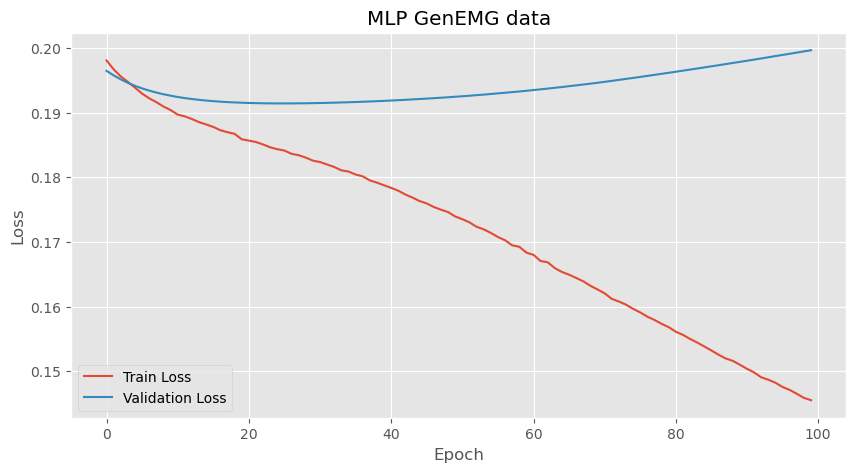

In [16]:
# Построение графиков потерь
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP GenEMG data')
plt.legend()
plt.grid(True)
plt.show()

Сгенерированные данные

In [17]:
# Создание модели и перенесение ее на устройство
model = FullyConnectedModel(input_size=8, hidden_size=128, output_channels=20, output_sequence_length=32).to(device)

# Используем функцию потерь и оптимизатор AdamW
criterion = nn.L1Loss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

# Количество эпох
num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Установка режима тренировки
    model.train()
    running_loss = 0.0

    # Добавляем tqdm для тренировочного цикла
    train_loader_tqdm = tqdm(
        simple_emg_train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False
    )

    for emg_batch, angles_batch in train_loader_tqdm:
        # Перенос данных на устройство
        emg_batch = emg_batch.to(device)
        angles_batch = angles_batch.to(device)

        # Прямой проход
        outputs = model(emg_batch)
        loss = criterion(outputs, angles_batch)

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0

    # Добавляем tqdm для валидационного цикла
    test_loader_tqdm = tqdm(
        simple_emg_test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False
    )

    with torch.no_grad():
        for emg_batch, angles_batch in test_loader_tqdm:
            # Перенос данных на устройство
            emg_batch = emg_batch.to(device)
            angles_batch = angles_batch.to(device)

            # Прямой проход
            outputs = model(emg_batch)
            loss = criterion(outputs, angles_batch)
            val_loss += loss.item()

    average_val_loss = val_loss / len(test_loader)

    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)

    # Обновляем основную строку вывода tqdm
    tqdm.write(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}"
    )

Epoch [1/100], Train Loss: 1.3012, Validation Loss: 1.2753


Epoch [2/100], Train Loss: 1.2540, Validation Loss: 1.2259


Epoch [3/100], Train Loss: 1.2013, Validation Loss: 1.1710


Epoch [4/100], Train Loss: 1.1453, Validation Loss: 1.1147


Epoch [5/100], Train Loss: 1.0896, Validation Loss: 1.0587


Epoch [6/100], Train Loss: 1.0341, Validation Loss: 1.0029


Epoch [7/100], Train Loss: 0.9787, Validation Loss: 0.9472


Epoch [8/100], Train Loss: 0.9231, Validation Loss: 0.8925


Epoch [9/100], Train Loss: 0.8692, Validation Loss: 0.8402


Epoch [10/100], Train Loss: 0.8179, Validation Loss: 0.7915


Epoch [11/100], Train Loss: 0.7707, Validation Loss: 0.7471


Epoch [12/100], Train Loss: 0.7278, Validation Loss: 0.7072


Epoch [13/100], Train Loss: 0.6898, Validation Loss: 0.6720


Epoch [14/100], Train Loss: 0.6566, Validation Loss: 0.6416


Epoch [15/100], Train Loss: 0.6278, Validation Loss: 0.6156


Epoch [16/100], Train Loss: 0.6032, Validation Loss: 0.5934


Epoch [17/100], Train Loss: 0.5822, Validation Loss: 0.5746


Epoch [18/100], Train Loss: 0.5644, Validation Loss: 0.5584


Epoch [19/100], Train Loss: 0.5491, Validation Loss: 0.5446


Epoch [20/100], Train Loss: 0.5360, Validation Loss: 0.5328


Epoch [21/100], Train Loss: 0.5245, Validation Loss: 0.5225


Epoch [22/100], Train Loss: 0.5147, Validation Loss: 0.5134


Epoch [23/100], Train Loss: 0.5061, Validation Loss: 0.5057


Epoch [24/100], Train Loss: 0.4983, Validation Loss: 0.4988


Epoch [25/100], Train Loss: 0.4918, Validation Loss: 0.4928


Epoch [26/100], Train Loss: 0.4858, Validation Loss: 0.4875


Epoch [27/100], Train Loss: 0.4805, Validation Loss: 0.4830


Epoch [28/100], Train Loss: 0.4760, Validation Loss: 0.4790


Epoch [29/100], Train Loss: 0.4718, Validation Loss: 0.4754


Epoch [30/100], Train Loss: 0.4683, Validation Loss: 0.4724


Epoch [31/100], Train Loss: 0.4651, Validation Loss: 0.4697


Epoch [32/100], Train Loss: 0.4623, Validation Loss: 0.4673


Epoch [33/100], Train Loss: 0.4597, Validation Loss: 0.4653


Epoch [34/100], Train Loss: 0.4575, Validation Loss: 0.4634


Epoch [35/100], Train Loss: 0.4557, Validation Loss: 0.4618


Epoch [36/100], Train Loss: 0.4540, Validation Loss: 0.4605


Epoch [37/100], Train Loss: 0.4525, Validation Loss: 0.4593


Epoch [38/100], Train Loss: 0.4510, Validation Loss: 0.4583


Epoch [39/100], Train Loss: 0.4497, Validation Loss: 0.4574


Epoch [40/100], Train Loss: 0.4488, Validation Loss: 0.4566


Epoch [41/100], Train Loss: 0.4476, Validation Loss: 0.4559


Epoch [42/100], Train Loss: 0.4468, Validation Loss: 0.4554


Epoch [43/100], Train Loss: 0.4460, Validation Loss: 0.4549


Epoch [44/100], Train Loss: 0.4452, Validation Loss: 0.4544


Epoch [45/100], Train Loss: 0.4447, Validation Loss: 0.4540


Epoch [46/100], Train Loss: 0.4439, Validation Loss: 0.4537


Epoch [47/100], Train Loss: 0.4435, Validation Loss: 0.4534


Epoch [48/100], Train Loss: 0.4428, Validation Loss: 0.4531


Epoch [49/100], Train Loss: 0.4427, Validation Loss: 0.4528


Epoch [50/100], Train Loss: 0.4419, Validation Loss: 0.4527


Epoch [51/100], Train Loss: 0.4415, Validation Loss: 0.4525


Epoch [52/100], Train Loss: 0.4412, Validation Loss: 0.4523


Epoch [53/100], Train Loss: 0.4406, Validation Loss: 0.4522


Epoch [54/100], Train Loss: 0.4404, Validation Loss: 0.4520


Epoch [55/100], Train Loss: 0.4400, Validation Loss: 0.4519


Epoch [56/100], Train Loss: 0.4400, Validation Loss: 0.4518


Epoch [57/100], Train Loss: 0.4393, Validation Loss: 0.4517


Epoch [58/100], Train Loss: 0.4391, Validation Loss: 0.4515


Epoch [59/100], Train Loss: 0.4388, Validation Loss: 0.4514


Epoch [60/100], Train Loss: 0.4384, Validation Loss: 0.4514


Epoch [61/100], Train Loss: 0.4381, Validation Loss: 0.4513


Epoch [62/100], Train Loss: 0.4380, Validation Loss: 0.4511


Epoch [63/100], Train Loss: 0.4377, Validation Loss: 0.4511


Epoch [64/100], Train Loss: 0.4373, Validation Loss: 0.4510


Epoch [65/100], Train Loss: 0.4370, Validation Loss: 0.4509


Epoch [66/100], Train Loss: 0.4369, Validation Loss: 0.4508


Epoch [67/100], Train Loss: 0.4364, Validation Loss: 0.4508


Epoch [68/100], Train Loss: 0.4365, Validation Loss: 0.4507


Epoch [69/100], Train Loss: 0.4361, Validation Loss: 0.4506


Epoch [70/100], Train Loss: 0.4358, Validation Loss: 0.4506


Epoch [71/100], Train Loss: 0.4355, Validation Loss: 0.4505


Epoch [72/100], Train Loss: 0.4355, Validation Loss: 0.4504


Epoch [73/100], Train Loss: 0.4351, Validation Loss: 0.4504


Epoch [74/100], Train Loss: 0.4348, Validation Loss: 0.4503


Epoch [75/100], Train Loss: 0.4345, Validation Loss: 0.4503


Epoch [76/100], Train Loss: 0.4344, Validation Loss: 0.4502


Epoch [77/100], Train Loss: 0.4342, Validation Loss: 0.4501


Epoch [78/100], Train Loss: 0.4339, Validation Loss: 0.4501


Epoch [79/100], Train Loss: 0.4337, Validation Loss: 0.4501


Epoch [80/100], Train Loss: 0.4335, Validation Loss: 0.4501


Epoch [81/100], Train Loss: 0.4333, Validation Loss: 0.4499


Epoch [82/100], Train Loss: 0.4332, Validation Loss: 0.4499


Epoch [83/100], Train Loss: 0.4330, Validation Loss: 0.4498


Epoch [84/100], Train Loss: 0.4327, Validation Loss: 0.4498


Epoch [85/100], Train Loss: 0.4327, Validation Loss: 0.4497


Epoch [86/100], Train Loss: 0.4323, Validation Loss: 0.4497


Epoch [87/100], Train Loss: 0.4323, Validation Loss: 0.4496


Epoch [88/100], Train Loss: 0.4319, Validation Loss: 0.4496


Epoch [89/100], Train Loss: 0.4317, Validation Loss: 0.4496


Epoch [90/100], Train Loss: 0.4315, Validation Loss: 0.4496


Epoch [91/100], Train Loss: 0.4314, Validation Loss: 0.4496


Epoch [92/100], Train Loss: 0.4312, Validation Loss: 0.4494


Epoch [93/100], Train Loss: 0.4311, Validation Loss: 0.4494


Epoch [94/100], Train Loss: 0.4308, Validation Loss: 0.4494


Epoch [95/100], Train Loss: 0.4306, Validation Loss: 0.4493


Epoch [96/100], Train Loss: 0.4305, Validation Loss: 0.4494


Epoch [97/100], Train Loss: 0.4303, Validation Loss: 0.4493


Epoch [98/100], Train Loss: 0.4304, Validation Loss: 0.4492


Epoch [99/100], Train Loss: 0.4298, Validation Loss: 0.4492


Epoch [100/100], Train Loss: 0.4299, Validation Loss: 0.4491


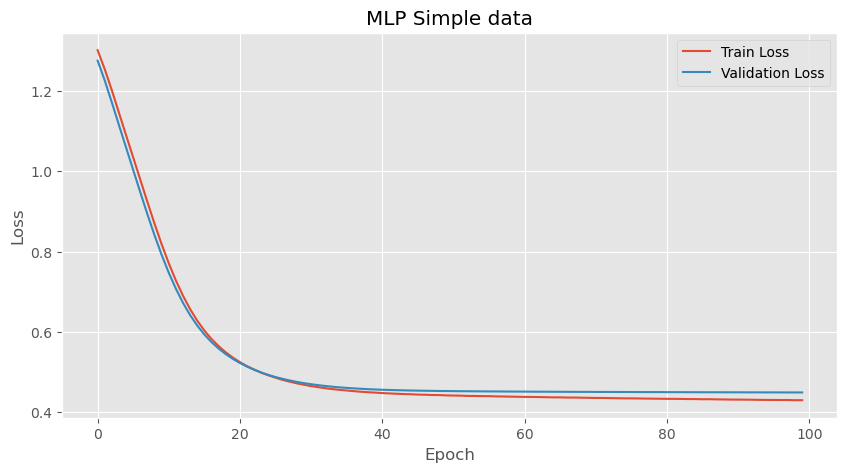

In [18]:
# Построение графиков потерь
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Simple data')
plt.legend()
plt.grid(True)
plt.show()

#### Bidirectional LSTM

In [24]:
# Определение устройства (CPU или CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Определение модели с Bidirectional LSTM
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=64, num_layers=1, output_size=20):
        super(BidirectionalLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dense = nn.Linear(hidden_size * 2, output_size)  # *2 для двунаправленной LSTM
        self.pool = nn.AvgPool1d(kernel_size=8, stride=8)  # Уменьшение длины в 8 раз

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Перемещение размерностей на (batch, seq_length, input_size)
        out, _ = self.lstm(x)
        out = self.dense(out)
        out = out.permute(0, 2, 1)  # Вернуть к (batch, output_size, sequence_length)
        out = self.pool(out)
        return out

Gen EMG данные

In [27]:
# Создание модели и перенесение ее на устройство
model = BidirectionalLSTMModel().to(device)

# Используем функцию потерь и оптимизатор AdamW
criterion = nn.L1Loss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

# Количество эпох
num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Установка режима тренировки
    model.train()
    running_loss = 0.0

    # Добавляем tqdm для тренировочного цикла
    train_loader_tqdm = tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False
    )

    for emg_batch, angles_batch in train_loader_tqdm:
        # Перенос данных на устройство
        emg_batch = emg_batch.to(device)
        angles_batch = angles_batch.to(device)

        # Прямой проход
        outputs = model(emg_batch)
        loss = criterion(outputs, angles_batch)

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0

    # Добавляем tqdm для валидационного цикла
    test_loader_tqdm = tqdm(
        test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False
    )

    with torch.no_grad():
        for emg_batch, angles_batch in test_loader_tqdm:
            # Перенос данных на устройство
            emg_batch = emg_batch.to(device)
            angles_batch = angles_batch.to(device)

            # Прямой проход
            outputs = model(emg_batch)
            loss = criterion(outputs, angles_batch)
            val_loss += loss.item()

    average_val_loss = val_loss / len(test_loader)

    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)

    # Обновляем основную строку вывода tqdm
    tqdm.write(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}"
    )

Epoch [1/100], Train Loss: 0.1948, Validation Loss: 0.1932


Epoch [2/100], Train Loss: 0.1938, Validation Loss: 0.1922


Epoch [3/100], Train Loss: 0.1929, Validation Loss: 0.1914


Epoch [4/100], Train Loss: 0.1921, Validation Loss: 0.1907


Epoch [5/100], Train Loss: 0.1915, Validation Loss: 0.1902


Epoch [6/100], Train Loss: 0.1911, Validation Loss: 0.1897


Epoch [7/100], Train Loss: 0.1910, Validation Loss: 0.1893


Epoch [8/100], Train Loss: 0.1905, Validation Loss: 0.1891


Epoch [9/100], Train Loss: 0.1898, Validation Loss: 0.1889


Epoch [10/100], Train Loss: 0.1901, Validation Loss: 0.1887


Epoch [11/100], Train Loss: 0.1899, Validation Loss: 0.1886


Epoch [12/100], Train Loss: 0.1898, Validation Loss: 0.1885


Epoch [13/100], Train Loss: 0.1898, Validation Loss: 0.1885


Epoch [14/100], Train Loss: 0.1895, Validation Loss: 0.1884


Epoch [15/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [16/100], Train Loss: 0.1895, Validation Loss: 0.1884


Epoch [17/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [18/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [19/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [20/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [21/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [22/100], Train Loss: 0.1899, Validation Loss: 0.1884


Epoch [23/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [24/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [25/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [26/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [27/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [28/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [29/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [30/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [31/100], Train Loss: 0.1894, Validation Loss: 0.1884


Epoch [32/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [33/100], Train Loss: 0.1894, Validation Loss: 0.1884


Epoch [34/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [35/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [36/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [37/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [38/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [39/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [40/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [41/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [42/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [43/100], Train Loss: 0.1899, Validation Loss: 0.1884


Epoch [44/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [45/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [46/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [47/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [48/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [49/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [50/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [51/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [52/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [53/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [54/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [55/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [56/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [57/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [58/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [59/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [60/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [61/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [62/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [63/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [64/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [65/100], Train Loss: 0.1895, Validation Loss: 0.1884


Epoch [66/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [67/100], Train Loss: 0.1895, Validation Loss: 0.1884


Epoch [68/100], Train Loss: 0.1895, Validation Loss: 0.1884


Epoch [69/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [70/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [71/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [72/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [73/100], Train Loss: 0.1894, Validation Loss: 0.1884


Epoch [74/100], Train Loss: 0.1895, Validation Loss: 0.1884


Epoch [75/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [76/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [77/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [78/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [79/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [80/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [81/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [82/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [83/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [84/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [85/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [86/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [87/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [88/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [89/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [90/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [91/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [92/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [93/100], Train Loss: 0.1899, Validation Loss: 0.1884


Epoch [94/100], Train Loss: 0.1898, Validation Loss: 0.1884


Epoch [95/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [96/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [97/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [98/100], Train Loss: 0.1896, Validation Loss: 0.1884


Epoch [99/100], Train Loss: 0.1897, Validation Loss: 0.1884


Epoch [100/100], Train Loss: 0.1895, Validation Loss: 0.1884


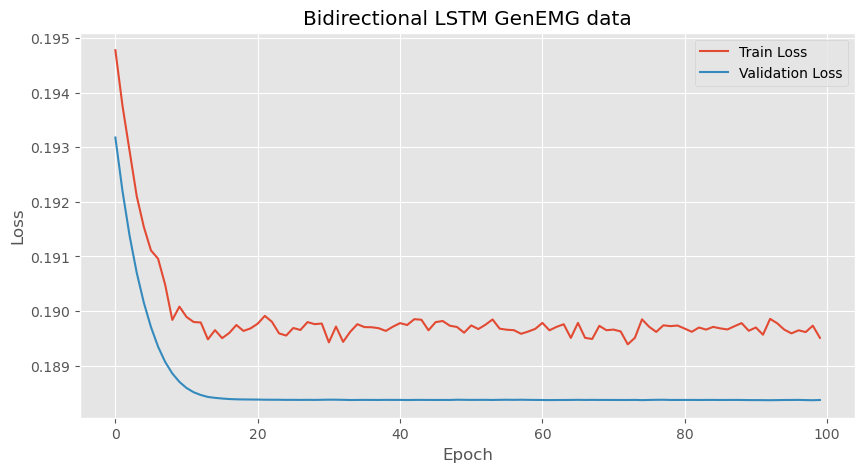

In [28]:
# Построение графиков потерь
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bidirectional LSTM GenEMG data')
plt.legend()
plt.grid(True)
plt.show()

Сгенерированные данные

In [25]:
# Создание модели и перенесение ее на устройство
model = BidirectionalLSTMModel().to(device)

# Используем функцию потерь и оптимизатор AdamW
criterion = nn.L1Loss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

# Количество эпох
num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Установка режима тренировки
    model.train()
    running_loss = 0.0

    # Добавляем tqdm для тренировочного цикла
    train_loader_tqdm = tqdm(
        simple_emg_train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False
    )

    for emg_batch, angles_batch in train_loader_tqdm:
        # Перенос данных на устройство
        emg_batch = emg_batch.to(device)
        angles_batch = angles_batch.to(device)

        # Прямой проход
        outputs = model(emg_batch)
        loss = criterion(outputs, angles_batch)

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0

    # Добавляем tqdm для валидационного цикла
    test_loader_tqdm = tqdm(
        simple_emg_test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False
    )

    with torch.no_grad():
        for emg_batch, angles_batch in test_loader_tqdm:
            # Перенос данных на устройство
            emg_batch = emg_batch.to(device)
            angles_batch = angles_batch.to(device)

            # Прямой проход
            outputs = model(emg_batch)
            loss = criterion(outputs, angles_batch)
            val_loss += loss.item()

    average_val_loss = val_loss / len(test_loader)

    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)

    # Обновляем основную строку вывода tqdm
    tqdm.write(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}"
    )

Epoch [1/100], Train Loss: 1.3000, Validation Loss: 1.2971


Epoch [2/100], Train Loss: 1.2935, Validation Loss: 1.2904


Epoch [3/100], Train Loss: 1.2867, Validation Loss: 1.2837


Epoch [4/100], Train Loss: 1.2798, Validation Loss: 1.2769


Epoch [5/100], Train Loss: 1.2729, Validation Loss: 1.2698


Epoch [6/100], Train Loss: 1.2658, Validation Loss: 1.2625


Epoch [7/100], Train Loss: 1.2581, Validation Loss: 1.2548


Epoch [8/100], Train Loss: 1.2500, Validation Loss: 1.2465


Epoch [9/100], Train Loss: 1.2418, Validation Loss: 1.2376


Epoch [10/100], Train Loss: 1.2324, Validation Loss: 1.2279


Epoch [11/100], Train Loss: 1.2228, Validation Loss: 1.2171


Epoch [12/100], Train Loss: 1.2112, Validation Loss: 1.2051


Epoch [13/100], Train Loss: 1.1983, Validation Loss: 1.1915


Epoch [14/100], Train Loss: 1.1842, Validation Loss: 1.1760


Epoch [15/100], Train Loss: 1.1677, Validation Loss: 1.1580


Epoch [16/100], Train Loss: 1.1483, Validation Loss: 1.1370


Epoch [17/100], Train Loss: 1.1256, Validation Loss: 1.1119


Epoch [18/100], Train Loss: 1.0984, Validation Loss: 1.0815


Epoch [19/100], Train Loss: 1.0654, Validation Loss: 1.0447


Epoch [20/100], Train Loss: 1.0253, Validation Loss: 0.9998


Epoch [21/100], Train Loss: 0.9768, Validation Loss: 0.9460


Epoch [22/100], Train Loss: 0.9198, Validation Loss: 0.8850


Epoch [23/100], Train Loss: 0.8572, Validation Loss: 0.8213


Epoch [24/100], Train Loss: 0.7954, Validation Loss: 0.7631


Epoch [25/100], Train Loss: 0.7417, Validation Loss: 0.7175


Epoch [26/100], Train Loss: 0.7019, Validation Loss: 0.6854


Epoch [27/100], Train Loss: 0.6738, Validation Loss: 0.6613


Epoch [28/100], Train Loss: 0.6510, Validation Loss: 0.6399


Epoch [29/100], Train Loss: 0.6307, Validation Loss: 0.6213


Epoch [30/100], Train Loss: 0.6134, Validation Loss: 0.6051


Epoch [31/100], Train Loss: 0.5980, Validation Loss: 0.5904


Epoch [32/100], Train Loss: 0.5838, Validation Loss: 0.5769


Epoch [33/100], Train Loss: 0.5710, Validation Loss: 0.5646


Epoch [34/100], Train Loss: 0.5591, Validation Loss: 0.5533


Epoch [35/100], Train Loss: 0.5481, Validation Loss: 0.5431


Epoch [36/100], Train Loss: 0.5383, Validation Loss: 0.5339


Epoch [37/100], Train Loss: 0.5296, Validation Loss: 0.5257


Epoch [38/100], Train Loss: 0.5216, Validation Loss: 0.5184


Epoch [39/100], Train Loss: 0.5148, Validation Loss: 0.5120


Epoch [40/100], Train Loss: 0.5086, Validation Loss: 0.5065


Epoch [41/100], Train Loss: 0.5032, Validation Loss: 0.5017


Epoch [42/100], Train Loss: 0.4985, Validation Loss: 0.4974


Epoch [43/100], Train Loss: 0.4944, Validation Loss: 0.4936


Epoch [44/100], Train Loss: 0.4906, Validation Loss: 0.4901


Epoch [45/100], Train Loss: 0.4873, Validation Loss: 0.4870


Epoch [46/100], Train Loss: 0.4842, Validation Loss: 0.4841


Epoch [47/100], Train Loss: 0.4815, Validation Loss: 0.4814


Epoch [48/100], Train Loss: 0.4786, Validation Loss: 0.4789


Epoch [49/100], Train Loss: 0.4762, Validation Loss: 0.4765


Epoch [50/100], Train Loss: 0.4738, Validation Loss: 0.4744


Epoch [51/100], Train Loss: 0.4719, Validation Loss: 0.4724


Epoch [52/100], Train Loss: 0.4698, Validation Loss: 0.4705


Epoch [53/100], Train Loss: 0.4681, Validation Loss: 0.4688


Epoch [54/100], Train Loss: 0.4664, Validation Loss: 0.4672


Epoch [55/100], Train Loss: 0.4647, Validation Loss: 0.4658


Epoch [56/100], Train Loss: 0.4632, Validation Loss: 0.4644


Epoch [57/100], Train Loss: 0.4621, Validation Loss: 0.4631


Epoch [58/100], Train Loss: 0.4606, Validation Loss: 0.4619


Epoch [59/100], Train Loss: 0.4597, Validation Loss: 0.4608


Epoch [60/100], Train Loss: 0.4585, Validation Loss: 0.4598


Epoch [61/100], Train Loss: 0.4577, Validation Loss: 0.4588


Epoch [62/100], Train Loss: 0.4566, Validation Loss: 0.4579


Epoch [63/100], Train Loss: 0.4558, Validation Loss: 0.4571


Epoch [64/100], Train Loss: 0.4548, Validation Loss: 0.4563


Epoch [65/100], Train Loss: 0.4544, Validation Loss: 0.4556


Epoch [66/100], Train Loss: 0.4536, Validation Loss: 0.4550


Epoch [67/100], Train Loss: 0.4529, Validation Loss: 0.4544


Epoch [68/100], Train Loss: 0.4522, Validation Loss: 0.4538


Epoch [69/100], Train Loss: 0.4518, Validation Loss: 0.4533


Epoch [70/100], Train Loss: 0.4514, Validation Loss: 0.4528


Epoch [71/100], Train Loss: 0.4509, Validation Loss: 0.4524


Epoch [72/100], Train Loss: 0.4504, Validation Loss: 0.4520


Epoch [73/100], Train Loss: 0.4499, Validation Loss: 0.4516


Epoch [74/100], Train Loss: 0.4500, Validation Loss: 0.4512


Epoch [75/100], Train Loss: 0.4493, Validation Loss: 0.4509


Epoch [76/100], Train Loss: 0.4490, Validation Loss: 0.4506


Epoch [77/100], Train Loss: 0.4488, Validation Loss: 0.4503


Epoch [78/100], Train Loss: 0.4484, Validation Loss: 0.4500


Epoch [79/100], Train Loss: 0.4481, Validation Loss: 0.4498


Epoch [80/100], Train Loss: 0.4479, Validation Loss: 0.4495


Epoch [81/100], Train Loss: 0.4477, Validation Loss: 0.4493


Epoch [82/100], Train Loss: 0.4473, Validation Loss: 0.4491


Epoch [83/100], Train Loss: 0.4471, Validation Loss: 0.4488


Epoch [84/100], Train Loss: 0.4468, Validation Loss: 0.4487


Epoch [85/100], Train Loss: 0.4467, Validation Loss: 0.4485


Epoch [86/100], Train Loss: 0.4466, Validation Loss: 0.4483


Epoch [87/100], Train Loss: 0.4465, Validation Loss: 0.4481


Epoch [88/100], Train Loss: 0.4462, Validation Loss: 0.4479


Epoch [89/100], Train Loss: 0.4459, Validation Loss: 0.4478


Epoch [90/100], Train Loss: 0.4458, Validation Loss: 0.4476


Epoch [91/100], Train Loss: 0.4460, Validation Loss: 0.4475


Epoch [92/100], Train Loss: 0.4457, Validation Loss: 0.4473


Epoch [93/100], Train Loss: 0.4453, Validation Loss: 0.4472


Epoch [94/100], Train Loss: 0.4454, Validation Loss: 0.4471


Epoch [95/100], Train Loss: 0.4452, Validation Loss: 0.4470


Epoch [96/100], Train Loss: 0.4450, Validation Loss: 0.4468


Epoch [97/100], Train Loss: 0.4450, Validation Loss: 0.4467


Epoch [98/100], Train Loss: 0.4450, Validation Loss: 0.4467


Epoch [99/100], Train Loss: 0.4449, Validation Loss: 0.4465


Epoch [100/100], Train Loss: 0.4448, Validation Loss: 0.4464


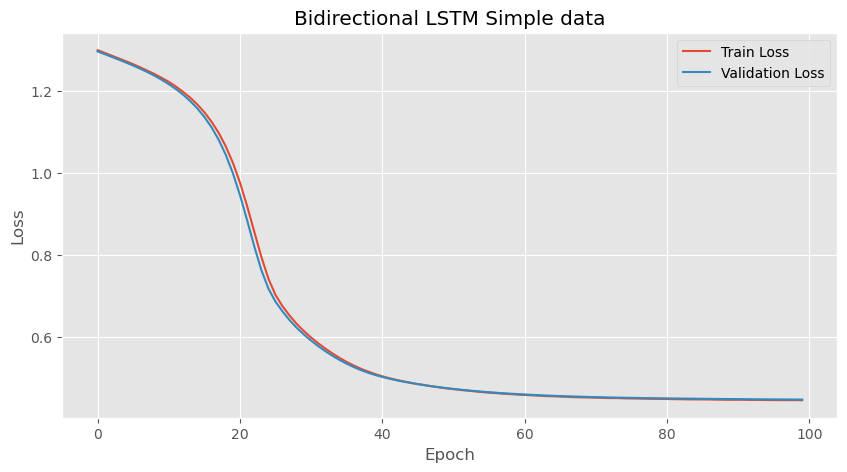

In [26]:
# Построение графиков потерь
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bidirectional LSTM Simple data')
plt.legend()
plt.grid(True)
plt.show()

#### HvatNet

In [4]:
# Определение устройства (CPU или CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hvatnet_v3_params = dict(
    n_electrodes=8,
    n_channels_out=20,
    n_res_blocks=3,
    n_blocks_per_layer=3,
    n_filters=128,
    kernel_size=3,
    strides=(2, 2, 2),
    dilation=2,
    use_angles=True,
)

Gen EMG данные

In [8]:
# Создание модели и перенесение ее на устройство
model = HVATNet_v3_FineTune.HVATNetv3(**hvatnet_v3_params).to(device)

# Используем функцию потерь и оптимизатор AdamW
criterion = nn.L1Loss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

# Количество эпох
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Установка режима тренировки
    model.train()
    running_loss = 0.0

    # Добавляем tqdm для тренировочного цикла
    train_loader_tqdm = tqdm(
        train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False
    )

    for emg_batch, angles_batch in train_loader_tqdm:
        # Перенос данных на устройство
        emg_batch = emg_batch.to(device)
        angles_batch = angles_batch.to(device)

        # Прямой проход
        outputs = model(emg_batch)
        loss = criterion(outputs, angles_batch)

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0

    # Добавляем tqdm для валидационного цикла
    test_loader_tqdm = tqdm(
        test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False
    )

    with torch.no_grad():
        for emg_batch, angles_batch in test_loader_tqdm:
            # Перенос данных на устройство
            emg_batch = emg_batch.to(device)
            angles_batch = angles_batch.to(device)

            # Прямой проход
            outputs = model(emg_batch)
            loss = criterion(outputs, angles_batch)
            val_loss += loss.item()

    average_val_loss = val_loss / len(test_loader)

    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)

    # Обновляем основную строку вывода tqdm
    tqdm.write(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}"
    )

Number of parameters:  4210788


Epoch [1/10], Train Loss: 0.1939, Validation Loss: 0.1904


Epoch [2/10], Train Loss: 0.1909, Validation Loss: 0.1892


Epoch [3/10], Train Loss: 0.1899, Validation Loss: 0.1891


Epoch [4/10], Train Loss: 0.1899, Validation Loss: 0.1888


Epoch [5/10], Train Loss: 0.1896, Validation Loss: 0.1888


Epoch [6/10], Train Loss: 0.1895, Validation Loss: 0.1888


Epoch [7/10], Train Loss: 0.1892, Validation Loss: 0.1889


Epoch [8/10], Train Loss: 0.1893, Validation Loss: 0.1889


Epoch [9/10], Train Loss: 0.1888, Validation Loss: 0.1889


Epoch [10/10], Train Loss: 0.1890, Validation Loss: 0.1890


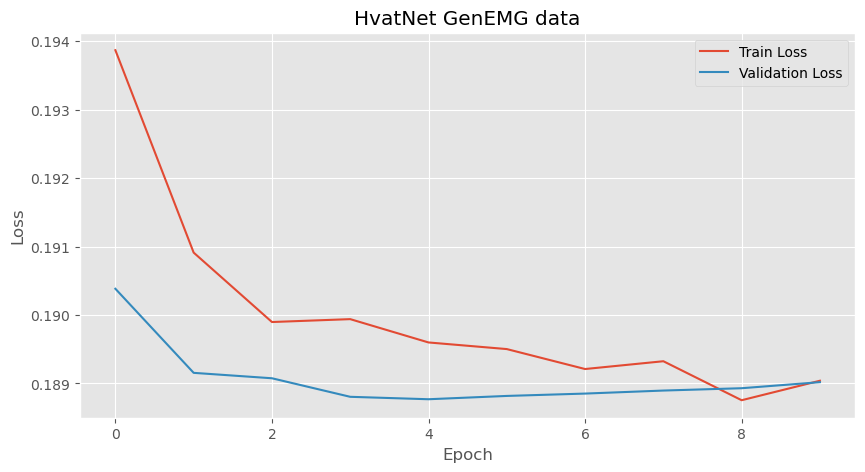

In [9]:
# Построение графиков потерь
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('HvatNet GenEMG data')
plt.legend()
plt.grid(True)
plt.show()

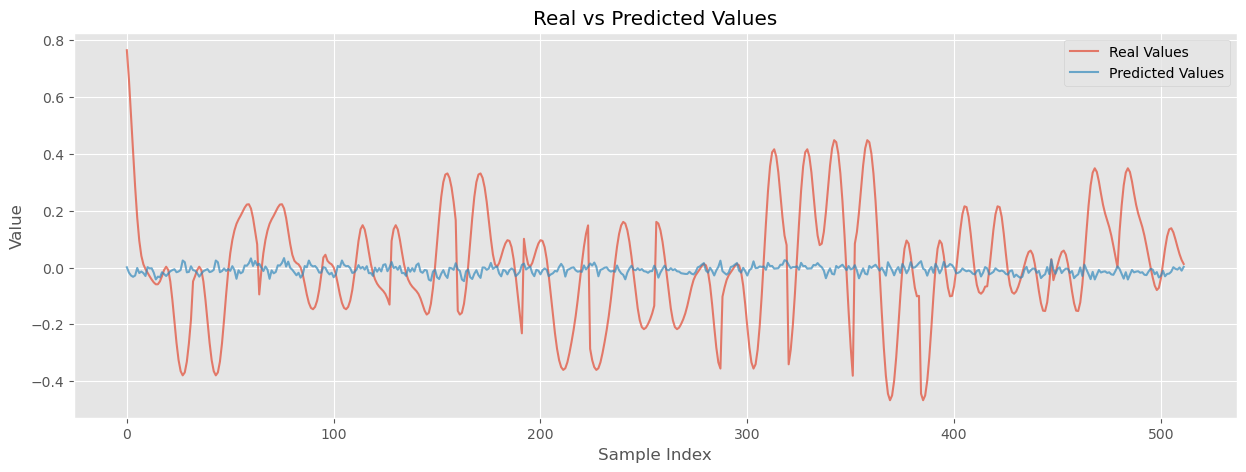

In [ ]:
import matplotlib.pyplot as plt
import torch

# Списки для сохранения реальных и предсказанных значений
real_values = []
predicted_values = []

# Вывод модели на валидационном наборе
model.eval()

with torch.no_grad():
    for emg_batch, angles_batch in test_loader:
        # Перенос данных на устройство
        emg_batch = emg_batch.to(device)
        angles_batch = angles_batch.to(device)

        # Прямой проход
        outputs = model(emg_batch)

        # Перенос на CPU и в numpy
        angles_batch = angles_batch.cpu().numpy()
        outputs = outputs.cpu().numpy()

        # Собираем данные. Тут, для простоты, учитывается только один канал и несколько первых временных шагов.
        real_values.extend(angles_batch[:16, 2, :].flatten())
        predicted_values.extend(outputs[:16, 2, :].flatten())
        break

# Преобразуем в numpy массивы для удобства (если еще не в numpy)
real_values = np.array(real_values)
predicted_values = np.array(predicted_values)

# Построим график
plt.figure(figsize=(15, 5))
plt.plot(real_values, label='Real Values', alpha=0.7)
plt.plot(predicted_values, label='Predicted Values', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Real vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
outputs.shape

(256, 20, 32)

In [48]:
angles_batch.shape

(256, 20, 32)

In [24]:
test_dataset[1][0]

tensor([[ 0.0449, -0.5180, -0.0879,  ..., -0.1746, -0.1168,  0.0452],
        [ 0.1700, -0.3120,  0.0907,  ...,  0.1865, -0.2389,  0.3665],
        [ 0.2989, -0.1722,  0.2541,  ...,  0.2014, -0.0434, -0.1381],
        ...,
        [ 0.1783, -0.1351, -0.2149,  ..., -0.1726,  0.2213, -0.0717],
        [-0.0019, -0.1187, -0.0773,  ...,  0.0091,  0.4862, -0.2003],
        [ 0.3063, -0.0522, -0.0396,  ..., -0.0159, -0.0460,  0.2497]])

In [43]:
a[1]

tensor([[ 0.0449, -0.5180, -0.0879,  ..., -0.1746, -0.1168,  0.0452],
        [ 0.1700, -0.3120,  0.0907,  ...,  0.1865, -0.2389,  0.3665],
        [ 0.2989, -0.1722,  0.2541,  ...,  0.2014, -0.0434, -0.1381],
        ...,
        [ 0.1783, -0.1351, -0.2149,  ..., -0.1726,  0.2213, -0.0717],
        [-0.0019, -0.1187, -0.0773,  ...,  0.0091,  0.4862, -0.2003],
        [ 0.3063, -0.0522, -0.0396,  ..., -0.0159, -0.0460,  0.2497]])

In [42]:
for a, b in test_loader:
    print(a, b)
    break


tensor([[[-0.1408, -0.1342,  0.0026,  ...,  0.0962, -0.2441, -0.0126],
         [ 0.1024, -0.0213, -0.4023,  ..., -0.3078,  0.2688,  0.2153],
         [ 0.1916, -0.1688,  0.1646,  ..., -0.2236,  0.1267, -0.2077],
         ...,
         [ 0.3215, -0.1028,  0.2377,  ...,  0.2828,  0.1599, -0.4292],
         [-0.0881,  0.0559, -0.0807,  ...,  0.2268,  0.2994, -0.1163],
         [-0.1286, -0.0481, -0.1044,  ...,  0.3447, -0.1817,  0.3037]],

        [[ 0.0449, -0.5180, -0.0879,  ..., -0.1746, -0.1168,  0.0452],
         [ 0.1700, -0.3120,  0.0907,  ...,  0.1865, -0.2389,  0.3665],
         [ 0.2989, -0.1722,  0.2541,  ...,  0.2014, -0.0434, -0.1381],
         ...,
         [ 0.1783, -0.1351, -0.2149,  ..., -0.1726,  0.2213, -0.0717],
         [-0.0019, -0.1187, -0.0773,  ...,  0.0091,  0.4862, -0.2003],
         [ 0.3063, -0.0522, -0.0396,  ..., -0.0159, -0.0460,  0.2497]],

        [[-0.0321,  0.2129, -0.2227,  ..., -0.2740, -0.0317,  0.0460],
         [-0.1403, -0.5386, -0.2590,  ...,  0

In [33]:
i

1

In [10]:
state = {
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "train_loss": average_train_loss,
    "val_loss": average_val_loss,
}

model_path = "../checkpoints/hvatnet-0411-genemg_data.pth"
torch.save(state, model_path)

Сгенерированные данные

In [5]:
# Создание модели и перенесение ее на устройство
model = HVATNet_v3_FineTune.HVATNetv3(**hvatnet_v3_params).to(device)

# Используем функцию потерь и оптимизатор AdamW
criterion = nn.L1Loss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

# Количество эпох
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Установка режима тренировки
    model.train()
    running_loss = 0.0

    # Добавляем tqdm для тренировочного цикла
    train_loader_tqdm = tqdm(
        simple_emg_train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False
    )

    for emg_batch, angles_batch in train_loader_tqdm:
        # Перенос данных на устройство
        emg_batch = emg_batch.to(device)
        angles_batch = angles_batch.to(device)

        # Прямой проход
        outputs = model(emg_batch)
        loss = criterion(outputs, angles_batch)

        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0

    # Добавляем tqdm для валидационного цикла
    test_loader_tqdm = tqdm(
        simple_emg_test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False
    )

    with torch.no_grad():
        for emg_batch, angles_batch in test_loader_tqdm:
            # Перенос данных на устройство
            emg_batch = emg_batch.to(device)
            angles_batch = angles_batch.to(device)

            # Прямой проход
            outputs = model(emg_batch)
            loss = criterion(outputs, angles_batch)
            val_loss += loss.item()

    average_val_loss = val_loss / len(test_loader)

    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)

    # Обновляем основную строку вывода tqdm
    tqdm.write(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}"
    )

Number of parameters:  4210788


Epoch [1/10], Train Loss: 1.2355, Validation Loss: 1.0993


Epoch [2/10], Train Loss: 0.9888, Validation Loss: 0.9162


Epoch [3/10], Train Loss: 0.9050, Validation Loss: 0.9064


Epoch [4/10], Train Loss: 0.8954, Validation Loss: 0.8879


Epoch [5/10], Train Loss: 0.8857, Validation Loss: 0.8851


Epoch [6/10], Train Loss: 0.8835, Validation Loss: 0.8804


Epoch [7/10], Train Loss: 0.8808, Validation Loss: 0.8790


Epoch [8/10], Train Loss: 0.8799, Validation Loss: 0.8774


Epoch [9/10], Train Loss: 0.8787, Validation Loss: 0.8766


Epoch [10/10], Train Loss: 0.8778, Validation Loss: 0.8757


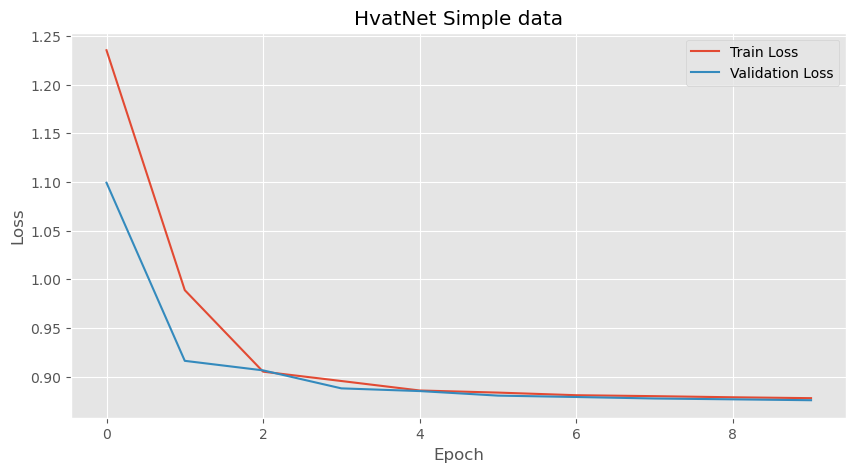

In [6]:
# Построение графиков потерь
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('HvatNet Simple data')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
state = {
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "train_loss": average_train_loss,
    "val_loss": average_val_loss,
}

model_path = "../checkpoints/hvatnet-0411-simple_data.pth"
torch.save(state, model_path)